In [2]:
# Find the cross correlation for all areas with all factors
# Identify for building, land and condo
# Sort all areas by cross correlation peak value
# Identify what is a relevant peak value


In [3]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from jre_utils.config import asset_types
from jre_utils.visualize import plot_time_series
from jre_utils.process import get_cumulative_growth, get_cumulative_growth_from_base

from jre_utils.datapath import (
    factor_data_paths,
    model_built_data_paths,
    get_derived_csv_path,
    get_derived_lpa_path,
    get_derived_plps_path,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [4]:
asset_type = "building"
years_ahead = 2

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

dataset_paths = {
    "transactions": get_derived_csv_path(asset_type),
    "lpa": get_derived_lpa_path(),
    "plps": get_derived_plps_path()
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key = "gmean"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric


In [5]:
dataset_key = "transactions"
core_path = dataset_paths[dataset_key]
population_path = factor_data_paths["processed"]["population"]["municipality"]
migration_path = factor_data_paths["processed"]["migration"]["municipality"]
taxable_income_path = factor_data_paths["processed"]["taxable_income"]["municipality"]
new_dwellings_path = factor_data_paths["processed"]["new_dwellings"]["municipality"]
lfs_revenue_path = factor_data_paths["processed"]["lfs_revenue_breakdown"]["municipality"]

dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
model_built_data_path = model_built_data_paths[dataset_name]

In [6]:
df = pd.read_csv(core_path)
df = df.assign(asset_type=asset_type)

population_df = pd.read_csv(population_path)
migration_df = pd.read_csv(migration_path)
taxable_income_df = pd.read_csv(taxable_income_path)
new_dwellings_df = pd.read_csv(new_dwellings_path)
lfs_revenue_df= pd.read_csv(lfs_revenue_path)

df = (
    df.merge(population_df, on=group_by_columns, how="left")
    .merge(migration_df, on=group_by_columns, how="left")
    .merge(taxable_income_df, on=group_by_columns, how="left")
    .merge(new_dwellings_df, on=group_by_columns, how="left")
    .merge(lfs_revenue_df, on=group_by_columns, how="left")
)

In [7]:
# prepare additional factors
df = df.sort_values(by=group_by_columns, ascending=True)
df["count_growth"] = df.groupby(granularity_columns)["count"].pct_change()
df["yearly_price_growth"] = df.groupby(granularity_columns)[metric].pct_change()
df["noise"] = np.random.normal(0, 1, df.shape[0])

# Finally, analyse 2010 onwards
df = df[df["year"] >= 2010]

In [8]:
area_code = 13101
area_df = df[df["area_code"] == area_code].sort_values(by="year", ascending=True)
area_df[granularity_columns + ["year", metric, "yearly_price_growth"]]

,area,area_code,year,unit_price_gmean,yearly_price_growth
1583,Tokyo-to Chiyoda-ku,13101,2010,2.011452e+06,0.074627
1584,Tokyo-to Chiyoda-ku,13101,2011,1.576321e+06,-0.216327
1585,Tokyo-to Chiyoda-ku,13101,2012,1.617590e+06,0.026180
1586,Tokyo-to Chiyoda-ku,13101,2013,2.345511e+06,0.450003
1587,Tokyo-to Chiyoda-ku,13101,2014,2.188612e+06,-0.066893
1588,Tokyo-to Chiyoda-ku,13101,2015,2.334554e+06,0.066683
1589,Tokyo-to Chiyoda-ku,13101,2016,2.480655e+06,0.062582
1590,Tokyo-to Chiyoda-ku,13101,2017,3.892463e+06,0.569127
1591,Tokyo-to Chiyoda-ku,13101,2018,3.167673e+06,-0.186203
1592,Tokyo-to Chiyoda-ku,13101,2019,3.045592e+06,-0.038540


In [10]:
growth_variables = [
    "yearly_price_growth",
    "taxable_income_growth",
    "total_tax_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
    "count_growth",
    "noise"
]

variables_to_compare = [
    "yearly_price_growth",
    "taxable_income_growth",
    "count_growth",
    "noise"
]

for variable in variables_to_compare:
    plot_time_series(
        area_df,
        variable,
        group_by_columns,
        granularity_columns,
        f"{variable} over time",
        width=1000,
        height=400,
        showlegend=False,
        # visible="legendonly",
        # highlight=True,
        # highlight_range=(2020, 2022)
    )

In [11]:
def get_prefecture_code(area_code):
    return int(area_code) // 1000

prefecture_codes = list(range(47 + 1)) # 0 for Japan and 1-47 for the prefectures

cross_correlation_dict = {
    area_code: {
        dep: {factor: {"lag": [], "corr": [], "corr_norm": []} for factor in growth_variables}
        for dep in growth_variables
    }
    for area_code in list(df["area_code"].unique()) + prefecture_codes
}

In [12]:
for area_code in df["area_code"].unique():
    area_df = df[df["area_code"] == area_code].sort_values(by="year", ascending=True)
    for factor in growth_variables:
        for dep in growth_variables:
            corr_df = area_df.set_index("year").dropna()
            dep_curve, factor_curve = corr_df[dep], corr_df[factor]

            if len(corr_df) > 0:
                # Lags
                lags = np.arange(-len(dep_curve) + 1, len(dep_curve))

                # Cross Corr
                cross_corr = np.correlate(dep_curve, factor_curve, mode="full")

                # Normalize Cross Corr
                auto_corr_x = np.correlate(dep_curve, dep_curve, mode="full")[
                    len(corr_df[dep]) - 1
                ]
                auto_corr_y = np.correlate(factor_curve, factor_curve, mode="full")[
                    len(corr_df[factor]) - 1
                ]

                normalization_factor = np.sqrt(auto_corr_x * auto_corr_y)
                cross_corr_normalized = cross_corr / normalization_factor

                # Store
                cross_correlation_dict[area_code][dep][factor]["lag"] = lags
                cross_correlation_dict[area_code][dep][factor]["corr"] = cross_corr
                cross_correlation_dict[area_code][dep][factor][
                    "corr_norm"
                ] = cross_corr_normalized

In [13]:
for prefecture_code in prefecture_codes:
    # break
    for factor in growth_variables:
        for dep in growth_variables:

            cross_corr_df = pd.DataFrame({"lag": []})

            for area_code in cross_correlation_dict.keys():
                if get_prefecture_code(area_code) == prefecture_code or prefecture_code == 0:
                    cross_corr_series = pd.DataFrame(
                        {
                            "lag": cross_correlation_dict[area_code][dep][factor][
                                "lag"
                            ],
                            area_code: cross_correlation_dict[area_code][dep][factor][
                                "corr_norm"
                            ],
                        }
                    )
                    cross_corr_df = cross_corr_df.merge(
                        cross_corr_series, on="lag", how="outer"
                    )

            prefecture_avg_cross_corr = (
                cross_corr_df.set_index("lag").sort_index().mean(axis=1)
            )

            cross_correlation_dict[prefecture_code][dep][factor][
                "lag"
            ] = prefecture_avg_cross_corr.index

            cross_correlation_dict[prefecture_code][dep][factor][
                "corr_norm"
            ] = prefecture_avg_cross_corr.values

In [14]:
area_codes_1 = [area_code for area_code in df["area_code"].unique() if get_prefecture_code(area_code) == 1]
# get random element on every run
area_codes_1[0]

1211

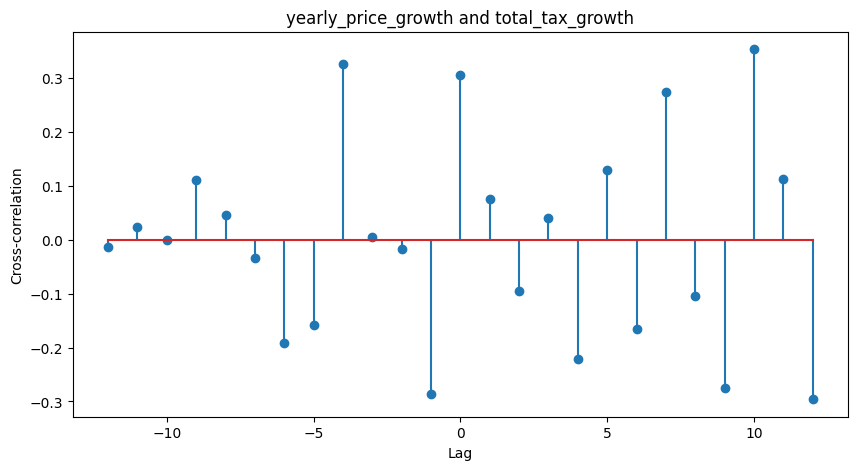

In [ ]:
area_code = 1211
x_var = "yearly_price_growth"
y_var = "total_tax_growth"

cross_corr_norm = cross_correlation_dict[area_code][x_var][y_var]["corr_norm"]
lags = cross_correlation_dict[area_code][x_var][y_var]["lag"]

# Plotting the cross-correlation vs lags
plt.figure(figsize=(10, 5))
plt.stem(lags, cross_corr_norm)
plt.title(f'{x_var} and {y_var}')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.show()

In [ ]:
area_df = df[df["area_code"] == 1211].sort_values(by="year", ascending=True)
area_df = area_df[["area", "area_code", "year", x_var, y_var]]
area_df

,area,area_code,year,yearly_price_growth,total_tax_growth
15382,Hokkaido Abashiri-shi,1211,2008,NaN,-0.004093
15383,Hokkaido Abashiri-shi,1211,2009,-0.060606,-0.037474
15384,Hokkaido Abashiri-shi,1211,2010,-0.035516,-0.011582
15385,Hokkaido Abashiri-shi,1211,2011,-0.182465,0.027094
15386,Hokkaido Abashiri-shi,1211,2012,0.046861,-0.007495
15387,Hokkaido Abashiri-shi,1211,2013,0.055499,-0.000158
15388,Hokkaido Abashiri-shi,1211,2014,0.306438,0.011289
15389,Hokkaido Abashiri-shi,1211,2015,-0.144939,-0.033766
15390,Hokkaido Abashiri-shi,1211,2016,-0.177116,0.031263
15391,Hokkaido Abashiri-shi,1211,2017,0.087500,0.000523


In [ ]:
corr_df = area_df.set_index("year").dropna()
dep_curve, factor_curve = corr_df[dep], corr_df[factor]

if len(corr_df) > 0:
    # Lags
    lags = np.arange(-len(dep_curve) + 1, len(dep_curve))

    # Cross Corr
    cross_corr = np.correlate(dep_curve, factor_curve, mode="full")

In [ ]:
for variable in [x_var, y_var]:
    plot_time_series(
        area_df,
        variable,
        group_by_columns,
        granularity_columns,
        f"{variable} over time",
        width=1000,
        height=400,
        showlegend=False,
        # visible="legendonly",
        # highlight=True,
        # highlight_range=(2020, 2022)
    )

In [ ]:
area_code = 1
x_var = "yearly_price_growth"

for y_var in growth_variables:
    cross_corr_norm = cross_correlation_dict[area_code][x_var][y_var]["corr_norm"]
    lags = cross_correlation_dict[area_code][x_var][y_var]["lag"]

    # Plotting the cross-correlation vs lags
    plt.figure(figsize=(10, 5))
    plt.stem(lags, cross_corr_norm)
    plt.title(f'{x_var} and {y_var}')
    plt.xlabel('Lag')
    plt.ylabel('Cross-correlation')
    plt.show()

NameError: name 'growth_variables' is not defined

In [ ]:
# Understand stationarity and do a test for it

import numpy as np

stock_price = np.array([1, 5, 1, 5, 10])
factor = np.array([10, 2, 10, 20, 4])

# No lag (0)
print(f"No Lag. Stock Price: {stock_price}, Factor: {factor}")
corr_0 = np.corrcoef(stock_price, factor)[0, 1]
print(corr_0)

# Factor leads by 1 (+1 lag)
print(f"Factor leads by 1. Stock Price: {stock_price[:-1]}, Factor: {factor[1:]}")
corr_plus1 = np.corrcoef(stock_price[:-1], factor[1:])[0, 1]
print(corr_plus1)

# Factor leads by 2 (+2 lags)
print(f"Factor leads by 2. Stock Price: {stock_price[:-2]}, Factor: {factor[2:]}")
corr_plus2 = np.corrcoef(stock_price[:-2], factor[2:])[0, 1]
print(corr_plus2)

# Stock leads by 1 (-1 lag)
print(f"Stock leads by 1. Stock Price: {stock_price[1:]}, Factor: {factor[:-1]}")
corr_minus1 = np.corrcoef(stock_price[1:], factor[:-1])[0, 1]
print(corr_minus1)

# Stock leads by 2 (-2 lags)
print(f"Stock leads by 2. Stock Price: {stock_price[2:]}, Factor: {factor[:-2]}")
corr_minus2 = np.corrcoef(stock_price[2:], factor[:-2])[0, 1]
print(corr_minus2)

(corr_minus2, corr_minus1, corr_0, corr_plus1, corr_plus2)

No Lag. Stock Price: [ 1  5  1  5 10], Factor: [10  2 10 20  4]
-0.3108586268644902
Factor leads by 1. Stock Price: [1 5 1 5], Factor: [ 2 10 20  4]
-0.2857142857142857
Factor leads by 2. Stock Price: [1 5 1], Factor: [10 20  4]
0.9285714285714283
Stock leads by 1. Stock Price: [ 5  1  5 10], Factor: [10  2 10 20]
0.9999999999999999
Stock leads by 2. Stock Price: [ 1  5 10], Factor: [10  2 10]
0.064018439966448


(0.064018439966448,
 0.9999999999999999,
 -0.3108586268644902,
 -0.2857142857142857,
 0.9285714285714283)